相比main.ipynb main2.ipynb，将网络层数调整为6层，每一层的结点数不同，可变learning rate调整为1e-3~1e-6 在15000步内衰减

In [11]:
import gzip
import os 
from urllib.request import urlretrieve
import numpy as np

加载数据集

In [12]:
def get_mnist(path=None):
    url = 'http://yann.lecun.com/exdb/mnist/'
    files = ['train-images-idx3-ubyte.gz',
             'train-labels-idx1-ubyte.gz',
             't10k-images-idx3-ubyte.gz',
             't10k-labels-idx1-ubyte.gz']
    
    if path is None:
        path = os.path.join(os.path.expanduser('~'), 'data', 'mnist')

    os.makedirs(path, exist_ok=True)
    for file in files:
        if file not in os.listdir(path):
            urlretrieve(url+file, os.path.join(path, file))
            print("Downloaded {} to {}".format(file, path))
        
    def _images(path):
        with gzip.open(path) as f:
            pixels = np.frombuffer(f.read(), 'B', offset=16)
        return pixels.reshape(-1, 784).astype('float32') / 255
    
    def _labels(path):
        with gzip.open(path) as f:
            integer_labels = np.frombuffer(f.read(), 'B', offset=8)
        
        def _onehot(integer_labels):
            n_rows = len(integer_labels)
            n_cols = integer_labels.max() + 1
            onehot = np.zeros((n_rows, n_cols), dtype='uint8')
            onehot[np.arange(n_rows), integer_labels] = 1
            return onehot
        
        return _onehot(integer_labels)
    
    train_images = _images(os.path.join(path, files[0]))
    train_labels = _labels(os.path.join(path, files[1]))
    test_images = _images(os.path.join(path, files[2]))
    test_labels = _labels(os.path.join(path, files[3]))

    return train_images, train_labels, test_images, test_labels
    

In [13]:
train_images, train_labels, test_images, test_labels = get_mnist('./data')

In [14]:
train_images[202], type(train_images[0])

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

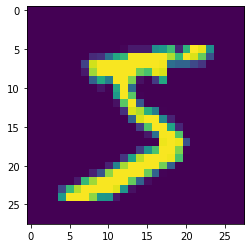

In [15]:
import matplotlib.pyplot as plt
plt.imshow(train_images[0].reshape(28, 28))

In [16]:
train_labels[0]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=uint8)

检查可以看到，得到的数据集中的图片格式为flatten过后的一个ndarray格式；而label格式均为独热编码

下面开始构造MLP模型（4层） input->hidden1->hidden2->hidden3->output

这里使用的He Initialization进行初始化。

In [17]:
# 定义6层MLP，定义每一个隐层的输出结点个数
H1_len = 512
H2_len = 256
H3_len = 128
H4_len = 64
H5_len = 32
H6_len = 10 # 分类为10类

# 获取训练数据的长度
X1_len = len(train_images[0]) + 1
X2_len = H1_len + 1
X3_len = H2_len + 1
X4_len = H3_len + 1
X5_len = H4_len + 1
X6_len = H5_len + 1

# 计算权重大小、初始化权重矩阵中的偏置和权重本身
# W1:(512, 785)
W1 = np.random.normal(0, np.sqrt(2/X1_len), (H1_len, X1_len))
W1[:, 0] = 0.0
# W2:(256, 513)
W2 = np.random.normal(0, np.sqrt(2/X2_len), (H2_len, X2_len))
W2[:, 0] = 0.0
# W3:(128, 257)
W3 = np.random.normal(0, np.sqrt(2/X3_len), (H3_len, X3_len))
W3[:, 0] = 0.0
# W4:(64, 129)
W4 = np.random.normal(0, np.sqrt(2/X4_len), (H4_len, X4_len))
W4[:, 0] = 0.0
# W5:(32, 65)
W5 = np.random.normal(0, np.sqrt(2/X5_len), (H5_len, X5_len))
W5[:, 0] = 0.0
# W6:(10, 33)
W6 = np.random.normal(0, np.sqrt(2/X6_len), (H6_len, X6_len))
W6[:, 0] = 0.0

构造激活函数及其导数

构造softmax函数

构造交叉熵损失函数

构造由Softmax操作后的交叉熵损失函数的导数

In [18]:
# 定义隐藏层激活函数sigmoid
def sigmoid(X):
    return 1 / (1 + np.exp(-X))

# 定义隐藏层激活函数sigmoid的导数
def dsigmoid(X):
    return sigmoid(X) * (1-sigmoid(X))

# 定义SoftMax
def softmax(X):
    exp_X = np.exp(X)
    sum_exp_X = np.sum(exp_X)
    return exp_X / sum_exp_X

# 定义ReLU
def ReLU(X):
    return np.where(X>=0, X, 0.0)

# 定义ReLU函数的导数
def dReLU(X):
    return np.where(X>=0, 1.0, 0.0)

# 定义交叉熵损失
def CrossEntropy(Y, Y_hat):
    """根据softmax结果Y_hat和Y计算交叉熵损失值"""
    # 通过Y的独热编码找到真正的标签
    true_index = np.where(Y == 1)[0][0]
    return -np.log(Y_hat[true_index])




# 定义交叉熵损失关于输入softmax的最后一层隐藏层的结点向量last_H的导数，需要给定Y和Y_hat
def dCrossEntropy_lastH_softmax(Y, Y_hat):
    """
    基于softmax后loss函数为交叉熵损失的情况下进行计算
    - Y:独热编码：如[0, 1, 0, 0, 0, ..., 0] 共10维 shapelike(10,)
    - Y_hat:SoftMax后的结果: 如[0.223, 0.112, 0.511, ..., 0] 共10维且所有维度的值加起来为1, shapelike(10,)
    - 返回值：是直接对最后一层隐藏节点last_H的导数，shapelike：(10,)
    """
    # 通过Y的独热编码找到真正的标签
    true_index = np.where(Y == 1)[0][0]
    # 由于已经经过数学证明验证得到了在SoftMax和CrossEntropy的双重作用下得到的求导公式
    # 所以直接使用结论
    dCrossEntropy_H = Y_hat
    dCrossEntropy_H[true_index] -= 1
    return dCrossEntropy_H

In [19]:
# 定义进行深度学习的学习率和epoch数
lr = 10e-3
# lr = np.linspace(10e-3, 10e-7, 15000)
epoch_num = 3

训练(每次单个样本的梯度下降)(这里调整了激活函数为ReLU)

In [20]:
step = 0
for i in range(epoch_num):
    j = 0
    every_steps = 100
    losses = np.zeros((every_steps,))
    for (img, Y) in zip(train_images, train_labels):
        # 给定输入，拼接并计算输出值
        X1 = np.concatenate((np.array([1]), img)) # X1:(785,)
        H1 = np.matmul(W1, X1)  # H1:(512,)
        X2 = np.concatenate((np.array([1]), ReLU(H1)))   # X2:(513,)
        H2 = np.matmul(W2, X2)  # H2:(256,)
        X3 = np.concatenate((np.array([1]), ReLU(H2)))   # X3:(257,)
        H3 = np.matmul(W3, X3)  # H3:(128,)
        X4 = np.concatenate((np.array([1]), ReLU(H3)))   # X4:(129,)
        H4 = np.matmul(W4, X4)  # H4:(64,)
        X5 = np.concatenate((np.array([1]), ReLU(H4)))   # X5:(65,)
        H5 = np.matmul(W5, X5)  # H5:(32,)
        X6 = np.concatenate((np.array([1]), ReLU(H5)))   # X6:(33,)
        H6 = np.matmul(W6, X6)  # H6:(10,)
        Y_hat = softmax(H6) # Y_hat:(10,)

        # 根据真实标签Y（独热编码）与预测标签Y_hat计算损失函数值
        loss = CrossEntropy(Y, Y_hat)

        # 计算各个梯度
        # 最后一层的特殊处理，直接计算交叉熵损失关于输入softmax的最后一层隐藏层的结点向量last_H的导数
        dL_H6 = dCrossEntropy_lastH_softmax(Y, Y_hat)   # (10,)
        dL_X6 = np.matmul(dL_H6, W6)    # (33,)
        dL_H5 = dL_X6[1:] * dReLU(H5)    # (32,)
        dL_X5 = np.matmul(dL_H5, W5)    # (65,)
        dL_H4 = dL_X5[1:] * dReLU(H4)    # (64,)
        dL_X4 = np.matmul(dL_H4, W4)    # (129,)
        dL_H3 = dL_X4[1:] * dReLU(H3)    # (128,)
        dL_X3 = np.matmul(dL_H3, W3)    # (257,)
        dL_H2 = dL_X3[1:] * dReLU(H2)    # (256,)
        dL_X2 = np.matmul(dL_H2, W2)    # (513,)
        dL_H1 = dL_X2[1:] * dReLU(H1)    # (512,)
        dL_X1 = np.matmul(dL_H1, W1)    # (785,)

        # 计算权重矩阵的梯度
        dL_W6 = np.matmul(dL_H6.reshape(-1, 1), X6.reshape(1, -1))
        dL_W5 = np.matmul(dL_H5.reshape(-1, 1), X5.reshape(1, -1))
        dL_W4 = np.matmul(dL_H4.reshape(-1, 1), X4.reshape(1, -1))
        dL_W3 = np.matmul(dL_H3.reshape(-1, 1), X3.reshape(1, -1))
        dL_W2 = np.matmul(dL_H2.reshape(-1, 1), X2.reshape(1, -1))
        dL_W1 = np.matmul(dL_H1.reshape(-1, 1), X1.reshape(1, -1))

        # 更新权重矩阵
        W6 -= lr * dL_W6
        W5 -= lr * dL_W5
        W4 -= lr * dL_W4
        W3 -= lr * dL_W3
        W2 -= lr * dL_W2
        W1 -= lr * dL_W1

        # 每隔every_steps轮，输出一下loss结果
        losses[j % every_steps] = loss
        j += 1
        if step < 15000-1:
            step += 1
        if j % every_steps == 0:
            print('Epoch{} IMG{}to{}, Average Loss:{}'.format(i, j-every_steps, j, np.mean(losses)))

        

Epoch0 IMG0to100, Average Loss:2.137620303645725
Epoch0 IMG100to200, Average Loss:1.8292473516367118
Epoch0 IMG200to300, Average Loss:1.463374097448878
Epoch0 IMG300to400, Average Loss:1.164908735728967
Epoch0 IMG400to500, Average Loss:1.0758788167778923
Epoch0 IMG500to600, Average Loss:1.1595755330148352
Epoch0 IMG600to700, Average Loss:1.014859136407235
Epoch0 IMG700to800, Average Loss:0.7976070929977963
Epoch0 IMG800to900, Average Loss:0.7951740519757012
Epoch0 IMG900to1000, Average Loss:0.8387512549137764
Epoch0 IMG1000to1100, Average Loss:1.0208824391076783
Epoch0 IMG1100to1200, Average Loss:0.695149337707236
Epoch0 IMG1200to1300, Average Loss:0.7517204274255076
Epoch0 IMG1300to1400, Average Loss:0.623619126627136
Epoch0 IMG1400to1500, Average Loss:0.5757553988500541
Epoch0 IMG1500to1600, Average Loss:0.6393208227154785
Epoch0 IMG1600to1700, Average Loss:0.5380696628640197
Epoch0 IMG1700to1800, Average Loss:0.46523356086959466
Epoch0 IMG1800to1900, Average Loss:0.6979672657559811


预测

In [21]:
def predict(img, printIt=False):
    # 给定输入，拼接并计算输出值
    X1 = np.concatenate((np.array([1]), img)) # X1:(785,)
    H1 = np.matmul(W1, X1)  # H1:(512,)
    X2 = np.concatenate((np.array([1]), ReLU(H1)))   # X2:(513,)
    H2 = np.matmul(W2, X2)  # H2:(256,)
    X3 = np.concatenate((np.array([1]), ReLU(H2)))   # X3:(257,)
    H3 = np.matmul(W3, X3)  # H3:(64,)
    X4 = np.concatenate((np.array([1]), ReLU(H3)))   # X4:(65,)
    H4 = np.matmul(W4, X4)  # H4:(10,)
    X5 = np.concatenate((np.array([1]), ReLU(H4)))   # X4:(65,)
    H5 = np.matmul(W5, X5)  # H4:(10,)
    X6 = np.concatenate((np.array([1]), ReLU(H5)))   # X4:(65,)
    H6 = np.matmul(W6, X6)  # H4:(10,)
    Y_hat = softmax(H6) # Y_hat:(10,)
    pred_label = np.argmax(Y_hat)
    if printIt:
        print('预测为数字{}'.format(np.argmax(Y_hat)))
    return Y_hat, pred_label

In [22]:
test_losses = []
accuracy = 0
for test_img, test_Y in zip(test_images, test_labels):
    test_Y_hat, pred_label = predict(test_img)
    true_label = np.where(test_Y==1)[0][0]
    test_loss = CrossEntropy(test_Y, test_Y_hat)
    test_losses.append(test_loss)
    accuracy += int(true_label == pred_label)
    print(true_label, pred_label)
accuracy /= len(test_images)
print('测试集平均损失为{}, 测试准确率为{}'.format(np.mean(test_losses), accuracy))

流式输出内容被截断，只能显示最后 5000 行内容。
9 9
9 9
8 8
4 4
1 1
0 0
6 6
0 0
9 9
6 6
8 8
6 6
1 1
1 1
9 9
8 8
9 9
2 2
3 3
5 5
5 5
9 9
4 4
2 2
1 1
9 9
4 4
3 3
9 9
6 6
0 0
4 4
0 0
6 6
0 0
1 1
2 2
3 3
4 4
7 7
8 8
9 9
0 0
1 1
2 2
3 3
4 4
7 7
8 8
9 9
0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
8 8
3 3
4 4
7 7
8 8
6 6
3 3
4 4
0 0
9 9
7 7
1 1
9 9
3 3
8 8
4 4
7 7
3 3
0 0
9 9
1 1
4 4
5 5
4 4
6 6
2 2
0 0
6 6
2 2
1 1
1 1
1 1
1 1
7 7
2 2
4 4
7 7
5 5
2 2
9 9
4 4
5 5
8 8
4 4
2 2
9 9
7 7
0 0
0 0
7 7
5 5
1 1
1 1
7 7
6 6
6 6
6 6
8 8
2 2
2 2
7 7
7 7
4 4
0 0
2 2
4 4
2 2
1 1
8 8
9 9
6 6
1 1
0 0
5 5
9 9
6 6
9 9
8 8
0 0
3 5
0 0
8 8
3 3
9 9
6 6
3 3
0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7
0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
5 5
4 4
8 8
7 7
4 4
7 7
7 7
3 3
9 9
8 8
8 8
3 3
1 1
5 5
8 8
2 2
7 7
4 4
2 2
1 1
5 5
4 4
5 5
5 5
8 8
6 6
4 4
4 4
4 4
1 1
8 8
7 7
5 5
5 5
1 1
8 8
9 9
1 1
3 3
6 6
3 3
3 3
2 2
2 2
6 6
9 9
9 9
6 6
5 5
5 5
3 3
3 3
8 8
1 1
6 6
5 5
6 6
8 8
1 1
9 9
7 7
6 6
8 8
3 3
7 7
4 4
7 7
0 0
9 9
0 0
0